# INFO371 Problem Set 6: Naive Bayes


## Introduction
In this problem set, we will use the Rotton Tomatoes dataset to implement our own, brand new, shiny Naive Bayes to categorize the quotes into rotten/fresh, and find the optimal smoothing parameters with our own, brand-even-newer k-fold cross validation. We also implement the three-fold data split with test data set aside for the final performance measure only.

## Rotten Tomatoes
Our first task is to load, clean and explore the Rotten Tomatoes movie reviews data. Briefly, approved critics can write reviews for movies, and evaluate the movie as "fresh" or "rotten". The webpage normally shows a short quote from each critic, and whether it was evaluated as fresh or rotten

The central variables in rotten-tomatoes.csv are the following: 

**critic** name of the critic

**fresh** evaluation: 'fresh' or 'rotten'

**quote** short version of the review

**review_date** when the review was written

There are more variables like links to IMDB.

## 1. Load Data
Load data and split it into working and testing chunks. Before we begin, let's ensure that we can save a dataframe in a format that we can load back in afterwards. pd.to_csv is a good bet, but it has a lot of options which may screw up the way the data is read. We will ensure that we can store data in a way that we can read it back in correctly, including that missings remain missings.

1) Create a tiny toy data frame that includes some numbers, strings, and missings. Save it and ensure you can reload it in the correct form.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = [['jon', 25], ['tom', 40], ['bob', ]] 
df = pd.DataFrame(data, columns = ['Name', 'Age'])
print(df)

  Name   Age
0  jon  25.0
1  tom  40.0
2  bob   NaN


In [3]:
df.to_csv(path_or_buf='toy.csv', index = False)

In [4]:
toy = pd.read_csv("toy.csv")
print(toy)

  Name   Age
0  jon  25.0
1  tom  40.0
2  bob   NaN


Now we are good to go.

2) Load the data

In [5]:
rotten = pd.read_csv("reviews.csv")
print("Number of cases:", len(rotten))

Number of cases: 13442


3) Split the dataset into working-testing parts (80/20 or so). Note that sklearn's train_test_split can easily handle dataframes.

In [6]:
train, test = train_test_split(rotten, test_size=0.20, random_state=42)

In [7]:
print("Length of train:", len(train))
print("Length of test:", len(test))

Length of train: 10753
Length of test: 2689


4) Save the test data and delete it from memory. Use python's del statement, or R-s rm function.

In [8]:
test.to_csv(path_or_buf='test.csv', index = False)
del test

## 2. Explore and clean the data
Now when the test data is put aside, we can breath out and take a closer look how does the work data look like.

1) Take a look at a few lines of data

In [9]:
train.head()

,critic,fresh,imdb,link,publication,quote,review_date,rtid,title
3372,Jonathan Rosenbaum,fresh,53459,http://onfilm.chicagoreader.com/movies/capsule...,Chicago Reader,As absurd and as beautiful as a fairy tale.,2007-09-26 00:00:00,770698712,Eyes Without a Face
3669,NaN,fresh,46250,"http://www.time.com/time/magazine/article/0,91...",TIME Magazine,The newcomer named Audrey Hepburn gives the po...,2009-02-02 00:00:00,18129,Roman Holiday
11132,Kenneth Turan,fresh,132347,http://www.calendarlive.com/movies/reviews/cl-...,Los Angeles Times,An effort you end up admiring more than comple...,2000-01-01 00:00:00,10623,Mystery Men
13084,Kevin Thomas,rotten,174204,http://www.calendarlive.com/movies/reviews/cl-...,Los Angeles Times,Much effort and expertise have gone into the m...,2000-01-01 00:00:00,15698,Simpatico
5507,Roger Ebert,fresh,91867,http://www.rogerebert.com/reviews/a-room-with-...,Chicago Sun-Times,"It is an intellectual film, but intellectual a...",2000-01-01 00:00:00,17636,A Room With A View


2) Print out all variable names.

In [10]:
print('Variable names: \n', list(train))

Variable names: 
 ['critic', 'fresh', 'imdb', 'link', 'publication', 'quote', 'review_date', 'rtid', 'title']


3) Create a summary table (maybe more like a bullet list) that prints out the most important summary statistics for the most interesting variables. The most interesting facts should include: 

a) number of missings for fresh and quote; 
b) all different values for fresh/rotten evaluations; 
c) counts or percentages of these values; 
d) number of zero-length or only whitespace quotes; 
e) minimum-maximum-average length of quotes (either in words, or in characters); 
f) how many reviews are in data multiple times

- number of missings for fresh and quote

In [11]:
na = train.isnull().sum()
print(na)

critic         572
fresh            0
imdb             0
link             0
publication      0
quote            0
review_date      0
rtid             0
title            0
dtype: int64


- all different values for fresh/rotten evaluations

In [12]:
print('Different evaluation values: \n', train.fresh.unique())

Different evaluation values: 
 ['fresh' 'rotten' 'none']


- counts or percentages of these values

In [13]:
print('Percentages of evaluation values: \n', train['fresh'].value_counts(normalize=True) * 100)

Percentages of evaluation values: 
 fresh     62.140798
rotten    37.682507
none       0.176695
Name: fresh, dtype: float64


- number of zero-length or only whitespace quotes

In [14]:
print('Number of zero-length quotes:', len(train[train.quote.str.len() == 0]))

Number of zero-length quotes: 0


- minimum-maximum-average length of quotes (either in words, or in characters)

In [15]:
quotes = train.quote
len_of_quote = [len(i) for i in quotes]
print('Maximum length of quote:', max(len_of_quote))
print('Minimum length of quote:', min(len_of_quote))
print('Average length of quote:', round(sum(len_of_quote)/len(len_of_quote), 2))

Maximum length of quote: 256
Minimum length of quote: 6
Average length of quote: 121.49


- how many reviews are in data multiple times

In [16]:
print('Number of duplicates:', len(train[train.duplicated() == True]))

Number of duplicates: 386


- Some extra summary statistics!

In [17]:
# Get other summary stats
summary = train.describe().transpose()
summary.columns = ['count','mean','std','min','25%','median','75%','max']
summary = summary[['count','mean','std','min','median','max']]
print(summary)

        count          mean           std      min    median          max
imdb  10753.0  1.559055e+05  1.669296e+05  13442.0  114113.0    1190539.0
rtid  10753.0  6.038135e+07  1.878349e+08     11.0   13380.0  771031792.0


4) Let's clean the by removing all the inconsistencies the table reveals. We have to ensure that the central variables: quote and fresh are not missing, and quote is not an empty string (or just contain spaces and such).

In [18]:
def clean(df):
    # remove 'none' for fresh
    df = df[df['fresh'] != 'none']
    # remove missing quotes?
    df = df[df.quote.str.len() > 0]
    # remove duplicates
    df.drop_duplicates(keep=False, inplace=True) 
    return(df)

In [19]:
train_clean = clean(train)

## 3. Naïve Bayes
It's time to get serious and implement the Naive Bayes classifier from scratch. But first things first:

Convert the data (quotes) into bag-of-words. Now we don't want a BOW that contains counts of words in quotes, but just 1/0 (or true/- false) for the presence/non-presence of the words. Convert the count-based BOW into such a presence BOW.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# initialize the vectorizer
vectorizer = CountVectorizer(min_df=0)

# `fit` builds the vocabulary
# transform your data into the BOW array
vectorizer.fit(train_clean.quote)
X = vectorizer.transform(train_clean.quote).toarray()
words_list = list(vectorizer.get_feature_names())

print(X, '\n')
print('Number of rows:', len(X))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Number of rows: 9984


In [21]:
X[X > 0] = 1

Split the work data and target (i.e. the variable fresh) into training and validation chunks (80/20 or so). Later we also do cross-validation, but for now, a simple training/validation will do.

In [22]:
vtrain, val = train_test_split(train_clean, test_size=0.20, random_state=42)

Now we are ready with the preparatory work and it's time to dive into the real thing. Let's implement Naive Bayes. Use only training data in the fitting below.

Compute the unconditional (log) probability that the tomato is fresh/rotten, log Pr(F), and log Pr(R). These probabilities are based on the values of fresh variable but not on the words the quotes contain.

In [23]:
probs = vtrain['fresh'].value_counts(normalize=True)
np.log(probs)

fresh    -0.487356
rotten   -0.952561
Name: fresh, dtype: float64

For each word w, compute log Pr(w|F) and log Pr(w|R), the (log) probability that the word is present in a fresh/rotten review. These probabilities can easily be calculated from counts of how many times these words are present for each class.

In [24]:
pr_fr = vtrain.fresh.value_counts(normalize=True)
pr_f, pr_r = np.log(pr_fr)

# get the indices that contain fresh or rotten
boolean_fresh = [1 if i == 'fresh' else 0 for i in train_clean.fresh]
fresh_indices = []
rotten_indices = []

for i, j in enumerate(boolean_fresh):
    if j == 1:
        fresh_indices.append(i)
    else:
        rotten_indices.append(i)
        
# probability of w|fresh
pr_w_f = np.divide(X[np.array(fresh_indices),:].sum(axis = 0).astype(float),X.sum(axis = 0).astype(float))

# probability of w|rotten
pr_w_r = np.divide(X[np.array(rotten_indices),:].sum(axis = 0).astype(float),X.sum(axis = 0).astype(float))

print('Raw probability:')
print('pr(w|f):\n', pr_w_f, '\n')
print("pr(w|r):\n", pr_w_r, '\n')


# take the log of probability
pr_w_f = np.log(pr_w_f)
pr_w_r = np.log(pr_w_r)
print('Log probabilities:')
print('log pr(w|f):\n', pr_w_f, '\n')
print('log pr(w|r):\n', pr_w_r, '\n')

Raw probability:
pr(w|f):
 [0.25       1.         0.71428571 ... 0.         0.66666667 0.        ] 

pr(w|r):
 [0.75       0.         0.28571429 ... 1.         0.33333333 1.        ] 

Log probabilities:
log pr(w|f):
 [-1.38629436  0.         -0.33647224 ...        -inf -0.40546511
        -inf] 

log pr(w|r):
 [-0.28768207        -inf -1.25276297 ...  0.         -1.09861229
  0.        ] 



C:\Users\Yasmine\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
C:\Users\Yasmine\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


Now we are done with the estimator. Our fitted model is completely described by these four probability vectors: log Pr(F), log Pr(R), log Pr(w|F), log Pr(w|R). Let's now turn to prediction, and pull out our validation data (not the test data!).

For both destination classes, F and R, compute the log-likelihood that the quote belongs to this class. Log-likelihood is essentially:

_li(c) = log Pr(c) + where c ∈ {F, R} is the class, i is the review, j indexes words, and wij is the j-th word of the review
i._

Computing these likelihoods involves sums of the previously computed probabilities, log Pr(w|F), and BOW elements xij. 

Based on the log-likelihoods, predict the class F or R for each quote in the validation set.

In [25]:
def predict(quote):
    words = quote.split(' ')
    word_idx = []
    for i in words:
        if i in words_list:
            word_idx.append(words_list.index(i))
    tmp_p_f = pr_f
    tmp_p_r = pr_r

    if len(word_idx)>0:
        tmp_p_f += np.sum(pr_w_f[np.array(word_idx)])
        tmp_p_r += pr_r + np.sum(pr_w_r[np.array(word_idx)])
    
    if tmp_p_f > tmp_p_r:
        return 1
    return 0

# use vtrain to predict
predicted = vtrain.quote.apply(predict).to_frame().quote
predicted = list(predicted)

Print the resulting confusion matrix and accuracy.

In [26]:
from sklearn.metrics import confusion_matrix

y = [1 if i == 'fresh' else 0 for i in vtrain.fresh]
output = [a == p for a,p in zip(predicted,y)]
accuracy = float(np.sum(output))/ float(len(output)) * 100
matrix = confusion_matrix(y, predicted)
print('Accuracy of the model:', accuracy)
print('Confusion Matrix:')
print(matrix)

Accuracy of the model: 81.59509202453987
Confusion Matrix:
[[1611 1470]
 [   0 4906]]


## 4. Interpretation
Now it is time to look at our fitted model a little bit closer. NB model probabilities are rather easy to understand and interpret. The task here is to find the best words to predict a fresh, and a rotten review. And we only want to look at words that are reasonably frequent, say more frequent than 30 times in the data.

1) Extract from the conditional probability vectors log Pr(F) and log Pr(R) the probabilities that correspond to frequent words only.

In [27]:
fresh_X = X[np.array(fresh_indices),:]
fresh_freq_idx = [i for (i,j) in enumerate(list(fresh_X.sum(axis = 0) >30)) if j == True]

rotten_X = X[np.array(rotten_indices),:]
rotten_freq_idx = [i for (i,j) in enumerate(list(rotten_X.sum(axis = 0) >30)) if j == True]

# log probability vectors of frequent words
top_p_f = pr_w_f[np.array(fresh_freq_idx)]
top_p_r = pr_w_r[np.array(rotten_freq_idx)]

2) Find 10 best words to predict F and 10 best words to predict R. 

In [28]:
top_f_idx = np.argsort(pr_w_f)[-10:]
top_r_idx = np.argsort(pr_w_r)[-10:]

top_f_words = [words_list[i] for i in top_f_idx]
top_r_words = [words_list[i] for i in top_r_idx]

print('Top fresh words:\n', top_f_words)
print('Top rotten words:\n', top_r_words)

Top fresh words:
 ['mumford', 'chafing', 'cesare', 'munro', 'cesar', 'murderer', 'certifiably', 'murkiness', 'murnau', 'largest']
Top rotten words:
 ['kinkiness', 'kidnapping', 'kidron', 'kiel', 'killings', 'kin', 'kinberg', 'kinder', 'staginess', 'zzzzzzzzz']


Here we see the top 10 words for fresh and rotten. For fresh, the top word is *mumford* and for rotten, the top word is *kinkiness*. We see some strange words, as described in the next prompt. This is because as mentioned above, when we have a review that contains just a single word, that word gains a lot of the weight. If a word also only appears once in the whole set, it will likely be classified as the only thing it was ever classified.

3) Print out a few missclassified quotes. Can we understand why these are misclassified?

Words from our top words, such as 'chafing,' 'mumford,' or 'zzzzzzzzz' appear to be misclassified because they do not really have any influence of the review really being "fresh."

We can probably attribute these words being misclassified becuase of the possibility that the words only appear once in the quotes. A review with only one word would also give that word a lot of weight in the model. This would mean that the BOW gives 100% or 0% probability of that word being what it was only classified as or has more weight from, hence some strange words coming into our top 10 "fresh" and "rotten"

## 5. NB with smoothing
Now we have our brand-new NB algorithm up and running. As a next step, we add smoothing to it. As we will be doing cross-validation below, our first task is to mold what we did above into two funcions: one for fitting and another one for predicting.

1) Create two functions: one for fitting NB model, and another to predict outcome based on the fitted model.

As mentioned above, the model is fully described with 4 probabilities, so the fitting function may return such a list as the model; and the prediction function may take it as an input.

2) Add smoothing to the model. Smoothing amounts to assuming that we have seen every possible work α 0 times already, for both classes. (You can also assume you have seen the words α times for F and β times for R). Note that α does not have to be an integer, and typically the best α < 1.

In [29]:
def fitNB(X_train, y_train, alpha):
    global p_fresh, p_rotten, l_p_f, l_p_r, words_list
    
    # initialize the vectorizer
    vectorizer = CountVectorizer(min_df=0)

    # create the dictionary
    vectorizer.fit(X_train)

    # `fit` builds the vocabulary
    # transform your data into the BOW array
    X = vectorizer.transform(X_train).toarray()
    words_list = list(vectorizer.get_feature_names())

    n_fresh = np.sum(y_train == 'fresh') + alpha
    n_rotten = np.sum(y_train == 'rotten') + alpha
    n_total = n_fresh + n_rotten
    p_fresh = float(n_fresh) / float(n_total)
    p_rotten = float(n_rotten) / float(n_total)
    f_counts = X[y_train == 'fresh'].sum(axis = 0) + alpha
    r_counts = X[y_train == 'rotten'].sum(axis = 0) + alpha
    l_p_f = np.log(f_counts / n_fresh)
    l_p_r = np.log(r_counts / n_rotten)
    return p_fresh, p_rotten, l_p_f, l_p_r

In [30]:
def predictNB(quote):
    words = quote.split(' ')
    word_idx = []
    for i in words:
        if i in words_list:
            word_idx.append(words_list.index(i))
    tmp_p_f = p_fresh
    tmp_p_r = p_rotten
    
    if len(word_idx)>0:
        tmp_p_f += np.sum(l_p_f[np.array(word_idx)])
        tmp_p_r += pr_r + np.sum(l_p_r[np.array(word_idx)])
    
    # if prob of fresh is greater than prob of rotten
    if tmp_p_f > tmp_p_r:
        return 1
    return 0

3) Fit a few models with different α-s and see if the accuracy improves compared to the baseline case above.

In [31]:
X_quote = vtrain.quote
y = vtrain.fresh

y_output = val.fresh
y_output = [1 if i == 'fresh' else 0 for i in y_output]

for al in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    fitNB(X_quote, y, al)
    predicted = val.quote.apply(predictNB).to_frame().quote
    predicted = list(predicted)
    # finding accuracy
    output = [a == p for a,p in zip(predicted,y_output)]
    accuracy = float(np.sum(output))/ float(len(output)) * 100
    print('Alpha:', al)
    print('Accuracy of the model:', accuracy)

C:\Users\Yasmine\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
C:\Users\Yasmine\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


Alpha: 0.0
Accuracy of the model: 65.7486229344016
Alpha: 0.1
Accuracy of the model: 70.85628442663996
Alpha: 0.2
Accuracy of the model: 71.65748622934402
Alpha: 0.3
Accuracy of the model: 72.15823735603405
Alpha: 0.4
Accuracy of the model: 72.15823735603405
Alpha: 0.5
Accuracy of the model: 72.30846269404107
Alpha: 0.6
Accuracy of the model: 72.15823735603405
Alpha: 0.7
Accuracy of the model: 72.45868803204807
Alpha: 0.8
Accuracy of the model: 72.45868803204807
Alpha: 0.9
Accuracy of the model: 72.40861291937907
Alpha: 1
Accuracy of the model: 72.50876314471708


## 6. Cross-Validation
Finally, we do cross-validation. Let's implement this ourself and not use existing libraries.

- Implement k-fold CV as a function that a) puts the data into random order; b) splits these into k chunks; c) selects a chunk for testing and the others for training; d) trains your NB model on the training chunks; e) computes accuracy on training chunk; f) returns mean accuracy over all these k trials. The function should also take α as an argument, this is the hyperparameter you are going to optimize.

In [32]:
def split_data_frame(df, num_chunks): 
    listOfDf = list()
    chunk_size = len(df) // num_chunks
    for i in range(num_chunks):
        listOfDf.append(df[i*chunk_size:(i+1)*chunk_size])
    return listOfDf

In [33]:
def cross_val(data, k, alpha):
    print('Number of chunks:', k)
    print('Alpha:', alpha)
    
    chunks = split_data_frame(data, k)
    accuracy_list = []
    for chunk_df in chunks:
        tmp_train = data[~data.isin(chunk_df)]
        X_quote = tmp_train.quote.astype(str)
        y = tmp_train.fresh

        y_output = chunk_df.fresh
        y_output = [1 if i == 'fresh' else 0 for i in y_output]

        fitNB(X_quote, y, alpha)
        predicted = chunk_df.quote.apply(predictNB).to_frame().quote
        predicted = list(predicted)

        # finding accuracy
        output = [a == p for a,p in zip(predicted,y_output)]
        accuracy = float(np.sum(output))/ float(len(output)) * 100
        accuracy_list.append(accuracy)
       
        print('Accuracy:', accuracy)
    print('Average accuracy:', np.mean(accuracy_list))
    print('------')

- Find the optimal α by 5-fold CV using your own CV code. Find the cross-validated accuracies for a number of α-s between 0 and 1. Present the accuracy as a function of α on a plot and indicate which one is the best α.

In [34]:
for alpha in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    cross_val(train_clean, 5, alpha)

Number of chunks: 5
Alpha: 0.0


C:\Users\Yasmine\anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
C:\Users\Yasmine\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


Accuracy: 67.98597194388778
Accuracy: 67.08416833667334
Accuracy: 65.03006012024048
Accuracy: 66.18236472945893
Accuracy: 66.38276553106212
Average accuracy: 66.53306613226452
------
Number of chunks: 5
Alpha: 0.1
Accuracy: 71.29258517034069
Accuracy: 72.29458917835672
Accuracy: 69.83967935871743
Accuracy: 69.73947895791584
Accuracy: 70.49098196392785
Average accuracy: 70.7314629258517
------
Number of chunks: 5
Alpha: 0.2
Accuracy: 72.24448897795591
Accuracy: 72.59519038076152
Accuracy: 69.93987975951904
Accuracy: 70.29058116232466
Accuracy: 70.79158316633266
Average accuracy: 71.17234468937876
------
Number of chunks: 5
Alpha: 0.3
Accuracy: 72.89579158316634
Accuracy: 72.94589178356713
Accuracy: 70.44088176352705
Accuracy: 70.19038076152304
Accuracy: 71.14228456913828
Average accuracy: 71.52304609218437
------
Number of chunks: 5
Alpha: 0.4
Accuracy: 72.84569138276554
Accuracy: 73.04609218436873
Accuracy: 70.74148296593187
Accuracy: 70.39078156312625
Accuracy: 71.09218436873748
Avera

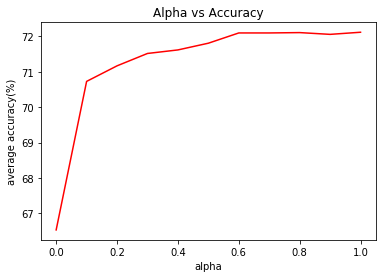

In [35]:
import matplotlib.pyplot as plt

alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
acc = [66.53, 70.73, 71.17, 71.52, 71.62, 71.81, 72.10, 72.10, 72.11, 72.06, 72.12]

plt.plot(alpha, acc, c = 'red')
plt.xlabel("alpha")
plt.ylabel("average accuracy(%)")
plt.title("Alpha vs Accuracy")
plt.show()

## 7. Final model performance
Finally, estimate the model performance on the testing data. Don't improve model after you have loaded testing data!

1) Fit the NB model using the cross-validated optimal alpha using the complete work data (both training and validation). This is the best and final model.

In [36]:
# optimal alpha: 1.0
fitNB(train_clean.quote, train_clean.fresh, 1.0)

(0.6156619266973763,
 0.38433807330262365,
 array([-8.03073492, -8.03073492, -6.93212264, ..., -8.7238821 ,
        -7.62526982, -8.7238821 ]),
 array([-6.64326876, -8.25270668, -7.15409439, ..., -7.5595595 ,
        -7.5595595 , -7.5595595 ]))

2) Load the testing data. Clean it using exactly the same procedure and transform it into BOW-s.

In [37]:
test_df = pd.read_csv("test.csv")
test_clean = clean(test_df)

y_output = test_clean.fresh
y_output = [1 if i == 'fresh' else 0 for i in y_output]

3) Predict the F/R class on testing data. Compute accuracy. Present it.

In [38]:
predicted = test_clean.quote.apply(predictNB).to_frame().quote
predicted = list(predicted)

output = [a == p for a,p in zip(predicted,y_output)]
accuracy = float(np.sum(output))/ float(len(output)) * 100

print('Accuracy:', accuracy)

Accuracy: 74.85736021300875


4) Did we get a better or worse result compared to the k-NN and TF-IDF in PS04?

We got about the same accuracy (~75%) as the k-NN and TF_IDF in PS04 (for k = 5). 